In [1]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 17
BATCH_SIZE = 32
INPUT_SIZE = (256, 256)

In [2]:
import torch


from trashcan_core.components.data_loader import CustomDataLoader
from trashcan_core.components.constants import MATERIAL_VERSION_PATH

data_loader = CustomDataLoader(MATERIAL_VERSION_PATH, batch_size=16)
data_loader.crop(*INPUT_SIZE)

Set lazy cropping to size (256, 256).


In [3]:
val_loader = data_loader.get_val_loader()

In [64]:
image = data_loader.dataset[0][0] 
masks = data_loader.dataset[0][1]

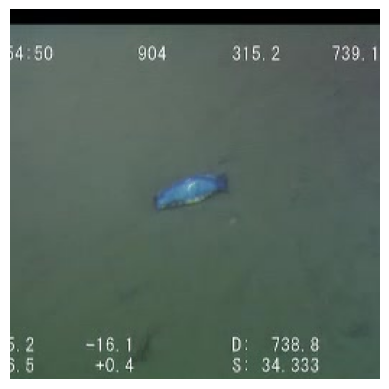

In [65]:
import matplotlib.pyplot as plt
import numpy as np


# Convert to numpy array and transpose to HWC format (128, 128, 3)
image_numpy = image.permute(1, 2, 0).cpu().numpy()

# Clip the pixel values to be in range [0, 1] or [0, 255] depending on the input range
# Assuming the image is in [0, 1] range (if it's normalized)
image_numpy = np.clip(image_numpy, 0, 1)

# Display the image
plt.imshow(image_numpy)
plt.axis('off')  # Hide axes
plt.show()


In [66]:
import onnxruntime as ort
import numpy as np
import torch

# Load ONNX model
onnx_model_path = "..\\models\\resunet34v8.onnx"  # Replace with your actual ONNX model file path
ort_session = ort.InferenceSession(onnx_model_path)

# Load a sample image and its corresponding mask

image_numpy = image.numpy().astype(np.float32)  # Convert to numpy and ensure it's float32

# Add a batch dimension to the image
image_numpy = np.expand_dims(image_numpy, axis=0)  # Shape becomes (1, C, H, W)

# Run ONNX model inference
outputs = ort_session.run(None, {"input": image_numpy})

# Postprocess the output
# Assume model predicts probabilities for 16 classes
predicted_probs = outputs[0]  # Get the first output (logits/probabilities)
predicted_class = np.argmax(predicted_probs, axis=1)  # Get the most likely class per pixel

# Display results
print(f"Predicted probabilities shape: {predicted_probs.shape}")  # Should be (1, num_classes, H, W)
print(f"Predicted class shape: {predicted_class.shape}")  # Should be (1, H, W)
  


Predicted probabilities shape: (1, 17, 256, 256)
Predicted class shape: (1, 256, 256)


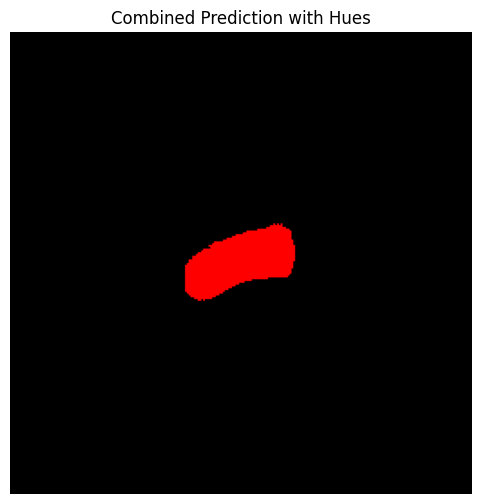

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Hues dictionary provided
NUM_CLASSES = 16  # You have 16 classes in the model output


# 2. Combine the classes into a colored image using HUES
# Initialize a blank image with 3 channels (RGB)

# Hues for each class
HUES = {
    "rov": 30,  # Distinct for robotic vehicle
    "plant": 120,  # Green for plants
    "animal_fish": 180,  # Blue for fish
    "animal_starfish": 300,  # Magenta for starfish
    "animal_shells": 240,  # Cyan for shells
    "animal_crab": 330,  # Pink-red for crabs
    "animal_eel": 210,  # Slightly different blue for eels
    "animal_etc": 270,  # Purple for other animals
    "trash_etc": 0,  # Red for other trash
    "trash_fabric": 45,  # Yellow for fabric
    "trash_fishing_gear": 90,  # Green for fishing gear
    "trash_metal": 15,  # Orange for metal
    "trash_paper": 60,  # Yellow-green for paper
    "trash_plastic": 135,  # Aqua for plastic
    "trash_rubber": 75,  # Olive for rubber
    "trash_wood": 150,  # Light green for wood
}

# Sample predicted_probs (example: shape [1, NUM_CLASSES, 128, 128])
# Ensure predicted_probs is normalized between 0 and 1
# predicted_probs = <Your model's prediction here>

# Initialize a blank HSV image
hsv_image = np.zeros((256, 256, 3), dtype=np.uint8)

# For each pixel, determine the class with the highest probability
predicted_classes = np.argmax(predicted_probs[0], axis=0) 

# Assign hues based on the predicted class
for class_idx in range(NUM_CLASSES):
    hue = HUES.get(f"class_{class_idx}", 0)  # Default hue 0 if not in HUES
    mask = predicted_classes == class_idx   # Mask for pixels belonging to this class
    hsv_image[..., 0][mask] = hue           # Set the hue for these pixels
    hsv_image[..., 1][mask] = 255           # Full saturation
    hsv_image[..., 2][mask] = 255           # Full value (brightness)

# Convert HSV to RGB for visualization
rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

# Display the combined image
plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title("Combined Prediction with Hues")
plt.axis('off')
plt.show()

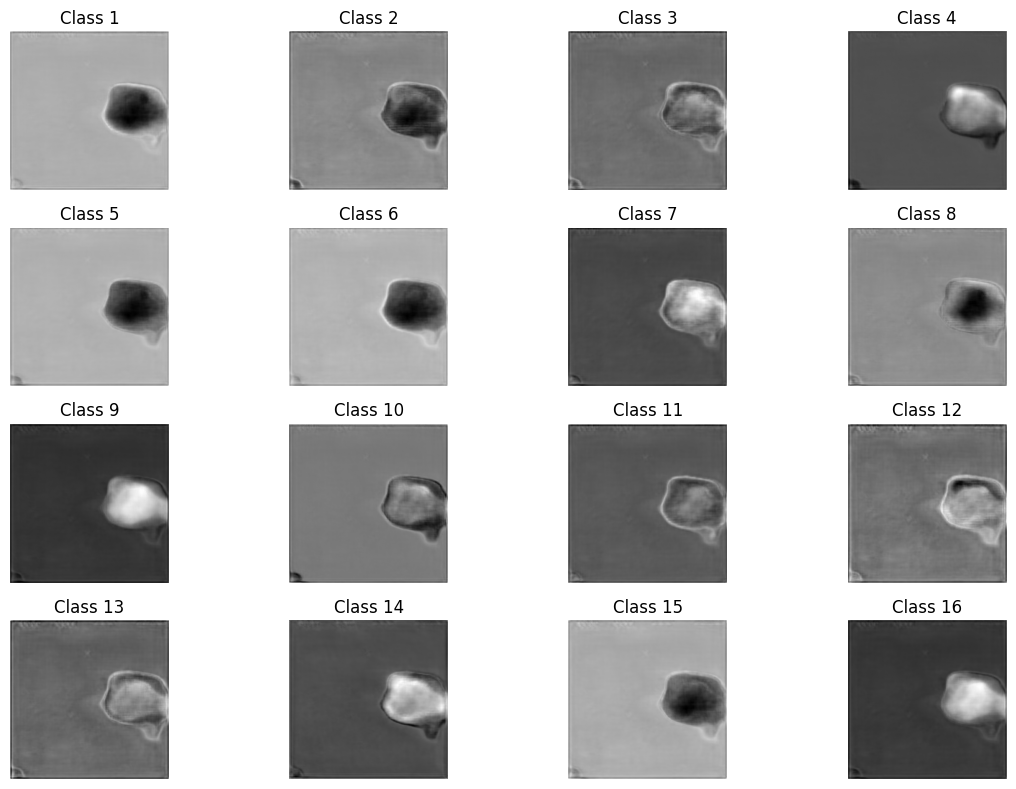

In [58]:

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    plt.subplot(4, 4, i+1)
    plt.imshow(predicted_probs[0, i], cmap="gray")
    plt.title(f"Class {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


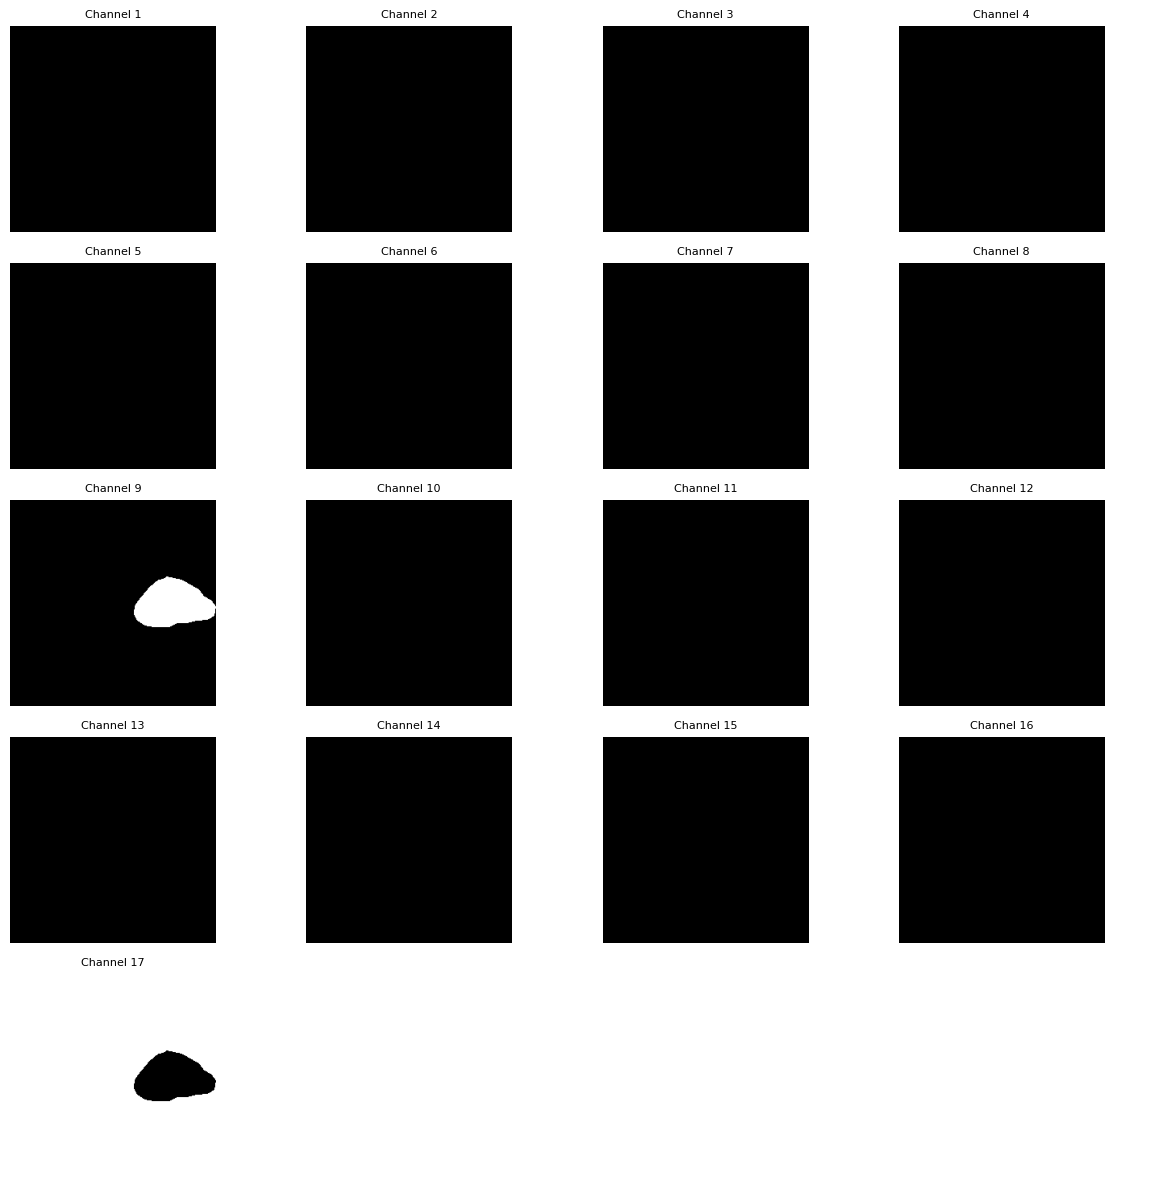

In [59]:
import matplotlib.pyplot as plt
import math

# Number of channels
num_channels = 17  

# Number of rows and columns for the grid
ncols = 4  # Number of columns (adjust as needed for layout)
nrows = math.ceil(num_channels / ncols)  # Compute the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

# Flatten axes for easy iteration
axes = axes.flatten()

for i in range(num_channels):
    # Get the mask for the i-th channel
    mask = masks[i].cpu().numpy()
    
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f'Channel {i+1}', fontsize=8)
    axes[i].axis('off')

for j in range(num_channels, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()